In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [2]:
%run _libraries.ipynb

In [14]:
%run _functions.ipynb

In [4]:
dir_save = 'docs/img/Section4-Linear-models-research'

# Section IV. Linear Models Comparing

## Load Saved Section if exists

## Load Data

In [5]:
# dicts
datasets_dict = loadit(
    'datasets_dict', dir='Section3-Feature-selection-and-Preprocessing')
features_dict = loadit(
    'features_dict', dir='Section3-Feature-selection-and-Preprocessing')
simulation_datasets_dict = loadit(
    'simulation_datasets_dict', dir='Section3-Feature-selection-and-Preprocessing')
estimators_dict = loadit(
    'estimators_dict', dir='Section3-Feature-selection-and-Preprocessing')
evaluation_dict = loadit(
    'evaluation_dict', dir='Section3-Feature-selection-and-Preprocessing')
# datasets
train = datasets_dict['train'].copy()
train_cv = datasets_dict['train_cv'].copy()
# features
features = features_dict['features']
numeric = features_dict['numeric']
ordinal = features_dict['ordinal']
categorical = features_dict['categorical']
categorical_transform = features_dict['categorical_transform']
factor = features_dict['factor']
target = features_dict['target']

## Elastic Net regularization effects

### Datasets

In [6]:
X = train_cv[features].copy()
y = train_cv[target]

In [7]:
X.shape

(1311, 104)

In [8]:
X.head()

,mssubclass,lg_lotfrontage,lg_lotarea,yearbuilt,lg_yearremodadd,lg_masvnrarea,lg_bsmtfinsf_first,lg_bsmtfinsf_second,lg_bsmtunfsf,lg_totalbsmtsf,...,lowqualfinsf_exst,second_flrsf_exst,garagearea_exst,wooddecksf_exst,openporchsf_exst,enclosedporch_exst,three_ssnporch_exst,screenporch_exst,poolarea_exst,miscval_exst
907,50,4.465908,9.350189,1936,7.594884,0.0,5.411646,0.0,6.678342,6.925595,...,0,1,1,0,0,0,0,1,0,0
782,20,4.219508,9.698061,2001,7.602401,0.0,0.000000,0.0,7.254178,7.254178,...,0,0,1,0,1,0,0,0,0,0
952,85,4.110874,8.881975,1972,7.602900,0.0,6.493754,0.0,4.691348,6.645091,...,0,0,1,1,0,0,0,0,0,0
620,30,3.828641,9.017847,1914,7.576097,0.0,3.737670,0.0,6.714171,6.762730,...,0,0,0,0,0,1,0,0,0,0
669,30,4.394449,9.358847,1922,7.576097,0.0,0.000000,0.0,6.552508,6.552508,...,0,0,1,0,0,1,0,0,0,0


In [9]:
y.head()

907    12.429216
782    12.139399
952    11.804849
620    11.112448
669    11.831379
Name: price, dtype: float64

### Preprocessors

In [10]:
encoder = OrdinalEncoder(
    encoding_method='ordered',
    variables=categorical_transform,
    missing_values='ignore',
    unseen='encode'
)

In [11]:
scaler = StandardScaler()

### Common Hyperparameters

In [12]:
alphas = np.logspace(-3, 3, 30)
n_folds = 5

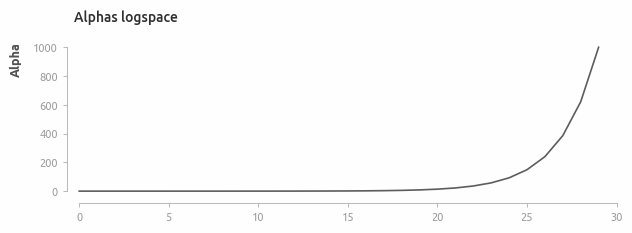

Image 'alphas_logspace.svg' successfully saved into 'img/Section4-Linear-models-research' directory


In [15]:
fig = plt.figure(figsize=(7, 2))
plt.plot(alphas)
# plt.grid(False)
plt.title('Alphas logspace')
axis_rstyle(
    x_ticks=[0, 30, 5],
    y_ticks=[0, 1000, 200])
plt.ylabel('Alpha')
plt.show()

savefig('alphas_logspace', dir_save)

### GridSearch

In [14]:
enet_cv_pipeline = Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
    ('estimator', ElasticNet(max_iter=100000))
])

In [15]:
enet_cv_pipeline

Pipeline(steps=[('encoder',
                 OrdinalEncoder(missing_values='ignore', unseen='encode',
                                variables=['mszoning', 'street', 'alley',
                                           'lotshape', 'landcontour',
                                           'utilities', 'lotconfig',
                                           'landslope', 'neighborhood',
                                           'condition_first',
                                           'condition_second', 'bldgtype',
                                           'housestyle', 'roofstyle',
                                           'roofmatl', 'exterior_first',
                                           'exterior_second', 'masvnrtype',
                                           'foundation', 'heating',
                                           'centralair', 'electrical',
                                           'paveddrive', 'fence', 'miscfeature',
                                           'saletype', 'salecondition',
                                           'mssubclass'])),
                ('scaler', StandardScaler()),
                ('estimator', ElasticNet(max_iter=100000))])

In [16]:
enet_params = [{
    'estimator__alpha': alphas
}]

In [17]:
enet_cv = GridSearchCV(
    estimator=enet_cv_pipeline,
    param_grid=enet_params,
    scoring='neg_root_mean_squared_error',
    cv=n_folds,
    refit=False
)

In [18]:
st = stopwatch.start()
enet_cv.fit(X, y)
print(f'Execution time: {stopwatch.stop(st)}')

Execution time: 0:00:29


In [19]:
enet_cv_best_score = abs(enet_cv.best_score_)
enet_cv_best_score

0.11780220227243528

In [20]:
enet_cv_best_params = {}

for key in enet_cv.best_params_.keys():
    new_key = key.lstrip('estimator')
    new_key = new_key.lstrip('__')
    enet_cv_best_params[new_key] = enet_cv.best_params_[key]
    
enet_cv_best_params

{'alpha': 0.001}

In [21]:
enet_cv_best_idx = enet_cv.best_index_
enet_cv_best_idx

0

In [22]:
enet_results = pd.DataFrame(enet_cv.cv_results_)

In [23]:
enet_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.180576,0.030900,0.051093,0.016180,0.001,{'estimator__alpha': 0.001},-0.121056,-0.117530,-0.127069,-0.105913,-0.117443,-0.117802,0.006900,1
1,0.159166,0.027753,0.074899,0.046821,0.00161,{'estimator__alpha': 0.0016102620275609393},-0.121724,-0.118353,-0.127824,-0.106611,-0.117451,-0.118393,0.006924,2
2,0.148845,0.028442,0.126972,0.094135,0.002593,{'estimator__alpha': 0.002592943797404667},-0.122506,-0.120474,-0.129290,-0.108059,-0.117159,-0.119498,0.006960,3
3,0.142270,0.018175,0.066768,0.041400,0.004175,{'estimator__alpha': 0.0041753189365604},-0.123097,-0.122284,-0.130471,-0.108922,-0.116673,-0.120289,0.007181,4
4,0.156042,0.032891,0.058448,0.016517,0.006723,{'estimator__alpha': 0.006723357536499335},-0.123214,-0.123222,-0.131506,-0.108492,-0.116150,-0.120517,0.007734,5


In [24]:
param_cols = [
    'param_estimator__alpha'
]
round_list = [4, 1]

In [25]:
# add params compact column
enet_results = cv_results_params_transform(
    enet_results, param_cols, round_list)

In [26]:
# abs all numeric
enet_results = enet_results.apply(
    lambda x: x.abs() if x.dtype.kind in 'iufc' else x)

In [27]:
loc_best_idx = enet_results['mean_test_score']==enet_cv_best_score
best_score_idx = enet_results[loc_best_idx].index.item()
best_score_idx

0

In [28]:
vars_plot = [
    'parameters',
    'split0_test_score', 'split1_test_score', 'split2_test_score',
    'split3_test_score', 'split4_test_score'
]
cv_results_prep = pd.melt(
    enet_results, id_vars='parameters',
    value_vars=vars_plot, value_name='rmse')
cv_results_prep.head()

,parameters,variable,rmse
0,0.001,split0_test_score,0.121056
1,0.0016,split0_test_score,0.121724
2,0.0026,split0_test_score,0.122506
3,0.0042,split0_test_score,0.123097
4,0.0067,split0_test_score,0.123214


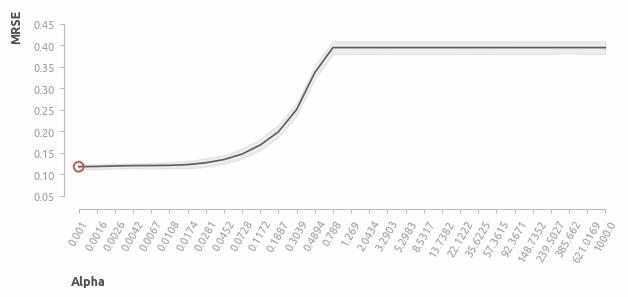

Image 'regularization.svg' successfully saved into 'img/Section4-Linear-models-research' directory


In [16]:
fig, ax = plt.subplots(figsize=(7, 2.5))

sns.lineplot(
    data=cv_results_prep,
    x='parameters',
    y='rmse',
    err_kws=({'alpha': 0.1})
)
sns.scatterplot(
    data=enet_results[enet_results['rank_test_score']==1],
    x='parameters',
    y='mean_test_score',
    s=50, color=palette[1], facecolor='none',
    ec=palette[1], linewidth=1.5, zorder=10, alpha=0.9
)
plt.xlabel(str.capitalize('Alpha'))
plt.ylabel('MRSE')
# ax.set_title('Elastic Net: regularization effect')
ax.tick_params(axis='x', rotation=60)
axis_rstyle(margin=(0.015, 0.25))

plt.grid(False)
plt.show()

savefig('regularization', dir_save)

### ELASTIC NET Model

In [30]:
enet_regressor = ElasticNet(
    **enet_cv_best_params,
    random_state=seed
)

In [31]:
enet = Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
    ('estimator', enet_regressor)
])

In [32]:
enet.fit(X,y)

Pipeline(steps=[('encoder',
                 OrdinalEncoder(missing_values='ignore', unseen='encode',
                                variables=['mszoning', 'street', 'alley',
                                           'lotshape', 'landcontour',
                                           'utilities', 'lotconfig',
                                           'landslope', 'neighborhood',
                                           'condition_first',
                                           'condition_second', 'bldgtype',
                                           'housestyle', 'roofstyle',
                                           'roofmatl', 'exterior_first',
                                           'exterior_second', 'masvnrtype',
                                           'foundation', 'heating',
                                           'centralair', 'electrical',
                                           'paveddrive', 'fence', 'miscfeature',
                                           'saletype', 'salecondition',
                                           'mssubclass'])),
                ('scaler', StandardScaler()),
                ('estimator', ElasticNet(alpha=0.001, random_state=42))])

In [33]:
enet_summary = pd.DataFrame({
    'feature': enet.feature_names_in_,
    'coeff': enet.named_steps['estimator'].coef_,
    'intercept': enet.named_steps['estimator'].intercept_
}).sort_values('coeff', key=abs, ascending=False)

In [34]:
enet_summary[enet_summary['coeff'] != 0].shape

(88, 3)

In [35]:
enet_summary.head(10)

,feature,coeff,intercept
13,lg_grlivarea,0.109304,12.024989
9,lg_totalbsmtsf,0.082895,12.024989
92,totalbsmtsf_exst,-0.080347,12.024989
35,overallqual,0.072446,12.024989
79,lg_flrsfmean,0.051306,12.024989
34,overallcond,0.043021,12.024989
60,neighborhood,0.035840,12.024989
19,kitchenabvgr,-0.034390,12.024989
2,lg_lotarea,0.031234,12.024989
6,lg_bsmtfinsf_first,0.027962,12.024989


### Features Research with Elastic Net

In [36]:
X_fr = X.copy()

In [37]:
pipe = Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
])

In [38]:
X_fr[features] = pipe.fit_transform(X_fr[features], y)

In [39]:
st = stopwatch.start()
results_sim_dict = simulation_enet_features(X_fr, y, alphas)
print(f'Execution time: {stopwatch.stop(st)}')

Execution time: 0:00:09


In [40]:
elnet_features_df = pd.DataFrame(results_sim_dict)

In [41]:
# save the list of lists with chosen features by enet in variable
features_chosen = elnet_features_df['features_list'].copy()

In [42]:
# modificate column 'features_list': list of strings -> string
# for more aesthetic view in df
elnet_features_df['features_list'] = \
    elnet_features_df['features_list'].apply(lambda x: ' , '.join(x))

In [43]:
elnet_features_df[elnet_features_df['features_num'] > 0]

,score,alpha,features_num,vif_max_value,features_list
0,0.106288,0.001000,88,504.2,"mssubclass , lg_lotfrontage , lg_lotarea , lg_..."
1,0.107548,0.001610,79,176.2,"mssubclass , lg_lotfrontage , lg_lotarea , lg_..."
2,0.109254,0.002593,68,157.3,"mssubclass , lg_lotfrontage , lg_lotarea , lg_..."
3,0.110799,0.004175,59,153.3,"mssubclass , lg_lotfrontage , lg_lotarea , lg_..."
4,0.112194,0.006723,55,152.8,"mssubclass , lg_lotfrontage , lg_lotarea , lg_..."
5,0.113713,0.010826,44,150.7,"mssubclass , lg_lotarea , lg_bsmtfinsf_first ,..."
6,0.116445,0.017433,38,150.2,"mssubclass , lg_lotarea , lg_bsmtfinsf_first ,..."
7,0.121491,0.028072,33,555.5,"mssubclass , lg_lotarea , yearbuilt , lg_bsmtf..."
8,0.130344,0.045204,28,148.3,"mssubclass , lg_lotarea , lg_bsmtfinsf_first ,..."
9,0.145161,0.072790,24,250.4,"mssubclass , lg_lotarea , lg_yearremodadd , lg..."


In [44]:
alpha_log = np.log(elnet_features_df['alpha'])

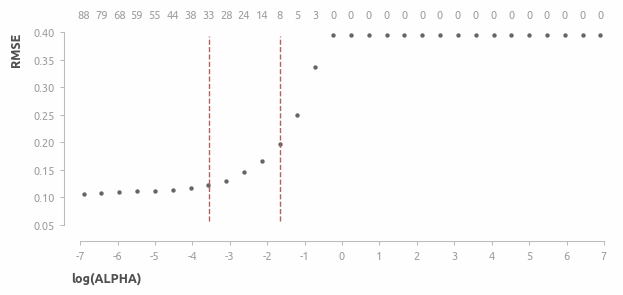

Image 'features_plot.svg' successfully saved into 'img/Section4-Linear-models-research' directory


In [17]:
xup_labels = elnet_features_df['features_num'].values
ticks = [int(i) for i in np.arange(-7, 7.1, 1)]

fig, ax = plt.subplots(figsize=(7, 2.5))
# f = plt.figure(figsize=(7, 2.5))
# plt.title('Features by Elastic Net', loc='left', pad=12)
plt.scatter(
    x=alpha_log, y=elnet_features_df['score'],
    ec='face', lw=0, s=10, alpha=0.95)
plt.xlabel('log(ALPHA)')
plt.ylabel('RMSE')
plt.xlim(-7.25, 7.25)
plt.ylim(0.08, 0.40)
plt.xticks(ticks=ticks, labels=ticks)
plt.grid(False)

axis_rstyle()
# top xaxis
xaxis_top = plt.twiny()
xaxis_top.set_xlim(-7.25, 7.25)
xaxis_top.set_xticks(ticks=alpha_log)
xaxis_top.spines['top'].set_position(('outward', 5))
xaxis_top.tick_params(left=False, bottom=False, top=False)
xaxis_top.set_xticklabels(labels=xup_labels, weight='normal', fontsize=8)
xaxis_top.grid(False)
xaxis_top.spines['left'].set_visible(False)
xaxis_top.spines['bottom'].set_visible(False)
# vertical red liness
plt.axvline(
    -1.65, ymin=0.02, ymax=0.98, linestyle='--',
    lw=1, color=palette[1], alpha=0.95)
plt.axvline(
    -3.55, ymin=0.02, ymax=0.98, linestyle='--',
    lw=1, color=palette[1], alpha=0.95)
ax.spines['bottom'].set_position(('outward', 12))

plt.show()

savefig('features_plot', dir_save)

In [46]:
features_chosen = \
    [element for sublist in features_chosen for element in sublist]

In [47]:
features_chosen_dict = {i:features_chosen.count(i) for i in features_chosen}

In [48]:
features_chosen_enet = pd.DataFrame({
    'feature': features_chosen_dict.keys(),
    'appeared': features_chosen_dict.values()
})
features_chosen_enet = (features_chosen_enet
                        .sort_values('appeared', ascending=False)
                        .reset_index(drop=True))

## Linear Regression for HousePricePredictor

### Features Selection

#### Correlation Matrix

In [49]:
corr_df = train[numeric + ordinal + [target]].corr()

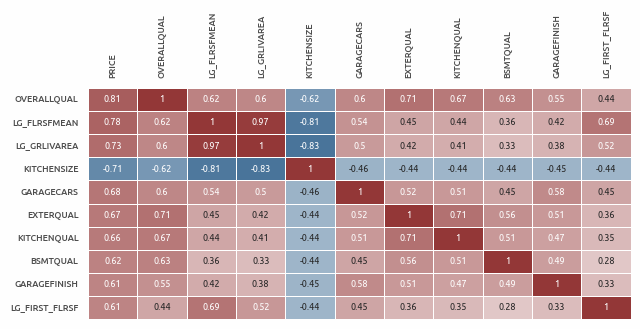

Image 'corr_matrix_linear.svg' successfully saved into 'img/Section4-Linear-models-research' directory


In [18]:
fig = plot_corr_matrix(
    data=corr_df, target=target, num_features=10,
    width=0.7, height=0.3, annot=6.5, labelsize=6.5,
    linecolor=theme, full=True, abs_results=True, df=False, df_limit=None)
plt.show()

savefig('corr_matrix_linear', dir_save, dpi=125)

In [51]:
features_chosen_enet.head(10)

,feature,appeared
0,overallqual,14
1,lg_flrsfmean,14
2,neighborhood,14
3,garagecars,13
4,garagefinish,12
5,bsmtqual,12
6,kitchenqual,12
7,exterqual,11
8,mssubclass,11
9,lg_first_flrsf,11


In [52]:
enet_summary.head(15)

,feature,coeff,intercept
13,lg_grlivarea,0.109304,12.024989
9,lg_totalbsmtsf,0.082895,12.024989
92,totalbsmtsf_exst,-0.080347,12.024989
35,overallqual,0.072446,12.024989
79,lg_flrsfmean,0.051306,12.024989
34,overallcond,0.043021,12.024989
60,neighborhood,0.035840,12.024989
19,kitchenabvgr,-0.034390,12.024989
2,lg_lotarea,0.031234,12.024989
6,lg_bsmtfinsf_first,0.027962,12.024989


In [53]:
print(features_chosen_enet['feature'].tolist())

['overallqual', 'lg_flrsfmean', 'neighborhood', 'garagecars', 'garagefinish', 'bsmtqual', 'kitchenqual', 'exterqual', 'mssubclass', 'lg_first_flrsf', 'modage', 'lg_lotarea', 'lg_bsmtfullbath', 'lg_grlivarea', 'fireplacequ', 'houseage', 'fireplaces', 'lg_bsmtfinsf_first', 'salecondition', 'centralair', 'bsmtexposure', 'functional', 'heatingqc', 'mszoning', 'overallcond', 'saletype', 'condition_first', 'garageage', 'exterior_first', 'kitchensize', 'foundation', 'poolqc', 'landcontour', 'roofstyle', 'bsmtfintype_first', 'paveddrive', 'kitchenabvgr', 'lg_wooddecksf', 'lg_screenporch', 'fence', 'totrmsabvgrd', 'fullbath', 'street', 'lotshape', 'utilities', 'halfbath', 'masvnrtype', 'roofmatl', 'bathsfracbedr', 'heating', 'alley', 'lotconfig', 'yrsold', 'lg_lotfrontage', 'garagetype', 'garagequal', 'miscval_exst', 'masvnrarea_exst', 'bsmtfinsf_second_exst', 'totalbsmtsf_exst', 'electrical', 'lg_bsmtunfsf', 'mosold', 'landslope', 'lg_totalbsmtsf', 'openporchsf_exst', 'three_ssnporch_exst', 'e

In [54]:
print(categorical)

['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition_first', 'condition_second', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior_first', 'exterior_second', 'masvnrtype', 'foundation', 'heating', 'centralair', 'electrical', 'paveddrive', 'fence', 'miscfeature', 'saletype', 'salecondition', 'mssubclass']


In [55]:
features_linear = [
    'lg_flrsfmean', 'overallqual', 'houseage',
    'lg_lotarea', 'overallcond', 'bsmtqual',
    'garagecars', 'kitchenqual', 'exterqual',  
]

In [56]:
len(features_linear)

9

In [57]:
data = train[features_linear + [target]].copy()

In [58]:
data_raw = data.copy()

In [59]:
data_cv = train_cv[features_linear + [target]].copy()

### Cut outliers

In [60]:
data.shape

(1311, 10)

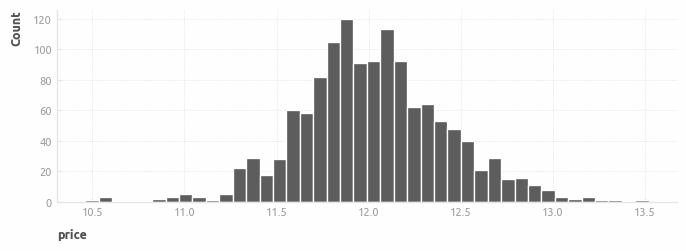

In [61]:
sns.histplot(data[target], bins=42, alpha=1);

In [62]:
target_trim = OutlierTrimmer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=target)

In [63]:
target_trim.fit(data)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both', variables='price')

In [64]:
data = target_trim.transform(data)

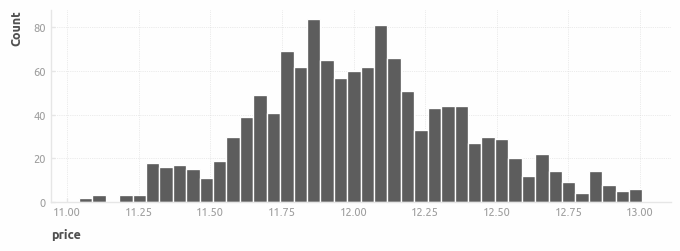

In [65]:
sns.histplot(data[target], bins=42, alpha=1);

In [66]:
data.shape

(1287, 10)

#### LINEAR REGRESSION

In [67]:
data.head()

,lg_flrsfmean,overallqual,houseage,lg_lotarea,overallcond,bsmtqual,garagecars,kitchenqual,exterqual,price
907,0.890837,0.658296,1.086695,0.460637,1.282781,0.589113,-1.035399,0.751124,1.063566,12.429216
782,0.208510,0.658296,-0.946281,1.132222,-0.519712,0.589113,0.312573,0.751124,1.063566,12.139399
952,-1.915383,-0.805701,0.004627,-0.443275,2.184027,0.589113,-1.035399,-0.768511,-0.692523,11.804849
620,-1.513143,-2.269698,1.873653,-0.180967,-2.322204,-0.561896,-2.383371,-0.768511,-0.692523,11.112448
669,-0.448245,-1.537699,1.545754,0.477350,-0.519712,-1.712905,-1.035399,-2.288146,-0.692523,11.831379


In [68]:
data, formula = lr_model_data_formula(
    data=data, target='price', predictors=features_linear)

In [69]:
data.shape

(1287, 10)

In [70]:
formula

'price ~ lg_flrsfmean + overallqual + houseage + lg_lotarea + overallcond + bsmtqual + garagecars + kitchenqual + exterqual'

In [71]:
# cov_type='HC3' - for robust confidence intervals (in case of heteroscedasticity)
lr = smf.ols(formula=formula, data=data).fit(cov_type='HC3')

In [72]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     1079.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:39:10   Log-Likelihood:                 857.47
No. Observations:                1287   AIC:                            -1695.
Df Residuals:                    1277   BIC:                            -1643.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.0263      0.004   3422.955      0.000      12.019      12.033
lg_flrsfmean     0.1444      0.005     26.261      0.000       0.134       0.155
overallqual      0.0880      0.007     12.850      0.000       0.075       0.101
houseage        -0.0854      0.007    -12.912      0.000      -0.098      -0.072
lg_lotarea       0.0613      0.004     14.534      0.000       0.053       0.070
overallcond      0.0559      0.004     12.679      0.000       0.047       0.065
bsmtqual         0.0460      0.005      9.310      0.000       0.036       0.056
garagecars       0.0316      0.006      5.566      0.000       0.020       0.043
kitchenqual      0.0268      0.005      4.878      0.000       0.016       0.038
exterqual        0.0200      0.005      3.701      0.000       0.009       0.031
==============================================================================
Omnibus:                      183.083   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              643.905
Skew:                          -0.671   Prob(JB):                    1.51e-140
Kurtosis:                       6.195   Cond. No.                         4.37
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [73]:
y_pred_lr = lr.predict(data[features_linear])

In [74]:
rmse_lr = mean_squared_error(data[target], y_pred_lr, squared=False)

In [75]:
rmse_lr

0.12428313100053122

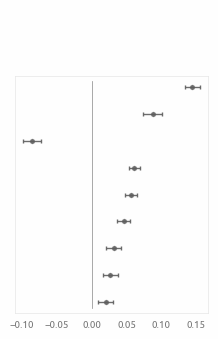

In [76]:
f = plot_lr_coef(lr, figsize=(2.5, 3.07))

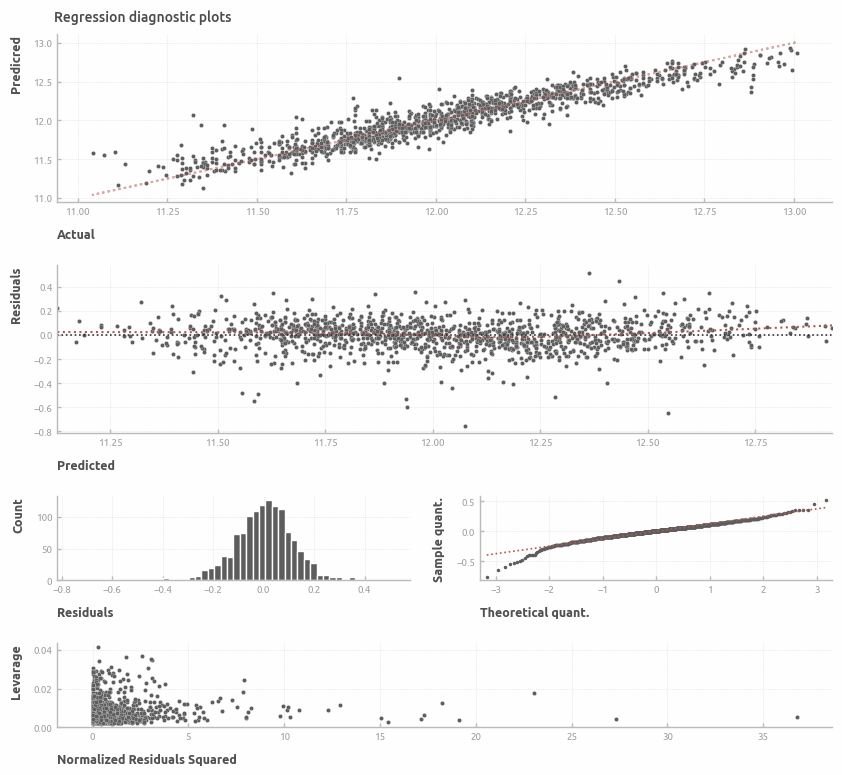

Image 'regression_diagnostics.svg' successfully saved into 'img/Section4-Linear-models-research' directory


In [19]:
fig = plot_regression_diagnostics(
    model=lr, 
    data=data,
    target=target,
    figsize=(10, 9)
)
fig.suptitle('Regression diagnostic plots', x=0.210, y=0.908, fontsize=10)
plt.show()

savefig('regression_diagnostics', dir_save)

In [78]:
regression_diagnostics(lr, data[features_linear], alpha=0.05)

,Test,Category,P or Statistic (s),Condition
0,Ramsey’s RESET,Model,0.0000,Non-linear effects
1,Fisher Criterion,Model,0.0000,Significant
2,VIF (s),Predictors,3.2070,No multicollinearity
3,Condition Number (s),Predictors,4.3654,No multicollinearity
4,Cook's Distance (s),Residuals,83,Outliers detected
5,One Sample t-test,Residuals,1.0000,Mean equals zero
6,One Sample Wilcoxon test,Residuals,0.1093,Mean equals zero
7,One Sample Bootstrap test (s),Residuals,10000,Mean equals zero
8,Kolmogorov-Smirnov,Residuals,0.0000,Not normal
9,Anderson-Darling (s),Residuals,5.9447,Not normal


In [79]:
outliers_idxs = get_cooksd_outliers_idxs(model=lr, data=data)

In [80]:
residuals_df = pd.concat(
    objs=[y_pred_lr.rename('Predicted'), lr.resid.rename('Residuals')],
    axis=1)

In [81]:
residuals_df.shape

(1287, 2)

In [82]:
residuals_df['Residuals'].std()

0.12433144320099562

In [83]:
residuals_trim = OutlierTrimmer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables='Residuals')

In [84]:
residuals_df_trimmed = residuals_trim.fit_transform(residuals_df)
residuals_df_trimmed = residuals_df_trimmed.rename(columns={'Residuals': 'Residuals trimmed'})

In [85]:
residuals_df_trimmed.shape

(1248, 2)

In [86]:
test_normality(residuals_df_trimmed['Residuals trimmed'])

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),0.5592,Normal
2,Shapiro-Wilk,0.0126,Not normal
3,Jarque-Bera,0.0977,Normal
4,D’Agostino-Pearson,0.0849,Normal


In [87]:
residuals_df_trimmed['Residuals trimmed'].std()

0.10351815888623953

In [88]:
normal_dist = np.random.normal(
    loc=0, scale=residuals_df['Residuals'].std(ddof=1), size=1288)

In [89]:
test_normality(normal_dist)

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),0.4448,Normal
2,Shapiro-Wilk,0.7034,Normal
3,Jarque-Bera,0.5858,Normal
4,D’Agostino-Pearson,0.6080,Normal


In [90]:
kurtosis(pd.concat([
    pd.DataFrame(normal_dist, columns=['Normal distribution']),
    residuals_df['Residuals'].to_frame(),
    residuals_df_trimmed['Residuals trimmed'].to_frame()
]))
    

,Kurtosis,Type
Residuals,3.212255,Too Peaked
Residuals trimmed,-0.204763,Normal
Normal distribution,-0.083337,Normal


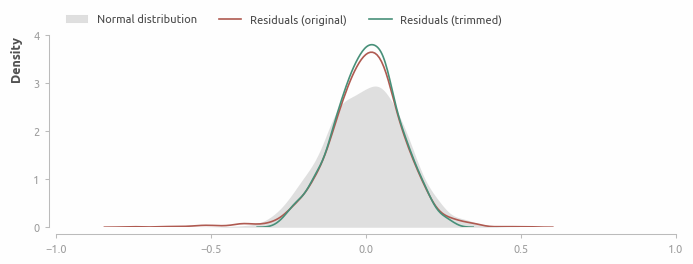

Image 'residuals_distributions_comparing.svg' successfully saved into 'img/Section4-Linear-models-research' directory


In [20]:
fig = plt.figure(figsize=(8, 2.5))

sns.kdeplot(normal_dist, lw=0.01, fill=True, color=alpha_color(palette[0], 0.75), label='Normal distribution')
sns.kdeplot(residuals_df['Residuals'], color=palette[1], label='Residuals (original)')
sns.kdeplot(residuals_df_trimmed['Residuals trimmed'], color=palette[3], label='Residuals (trimmed)')

plt.legend(**legend_inline, ncols=3)
# plt.title('Comparison of Residual distributions with and without outliers', **title_inline)
axis_rstyle(x_ticks=(-1.0, 1.0, 0.5), y_ticks=(0, 4, 1))
plt.grid(False)
plt.xlabel(None)
plt.show()

savefig('residuals_distributions_comparing', dir_save)

### Simulations and comparing with ELASTIC NET

In [92]:
data_cv.shape

(1311, 10)

In [93]:
data_cv.head()

,lg_flrsfmean,overallqual,houseage,lg_lotarea,overallcond,bsmtqual,garagecars,kitchenqual,exterqual,price
907,6.935370,7,70,9.350189,7,4,1,4,4,12.429216
782,6.735990,7,8,9.698061,5,4,2,4,4,12.139399
952,6.115373,5,37,8.881975,8,4,1,3,3,11.804849
620,6.232910,3,94,9.017847,3,3,0,3,3,11.112448
669,6.544081,4,84,9.358847,5,2,1,2,3,11.831379


#### Hyperparameters Search

In [94]:
enet_cv_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', ElasticNet(max_iter=100000))
])

In [95]:
enet_cv_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', ElasticNet(max_iter=100000))])

In [96]:
alphas = np.logspace(-3, 3, 30)
l1_ratio = np.arange(0.1, 1.0, 0.1)
n_folds_cv = 20

X = data_cv.loc[:, data_cv.columns!=target]
y = data_cv[target]

In [97]:
enet_params = [{
    'estimator__alpha': alphas,
    'estimator__l1_ratio': l1_ratio
}]

In [98]:
st = stopwatch.start()
enet_cv = GridSearchCV(
    estimator=enet_cv_pipeline,
    param_grid=enet_params,
    scoring='neg_root_mean_squared_error',
    cv=n_folds_cv,
    refit=False
)
print(f'Execution time: {stopwatch.stop(st)}')

Execution time: 0:00:00


In [99]:
enet_cv.fit(X, y)

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator',
                                        ElasticNet(max_iter=100000))]),
             param_grid=[{'estimator__alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01...-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03]),
                          'estimator__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}],
             refit=False, scoring='neg_root_mean_squared_error')

In [100]:
enet_cv_best_score = abs(enet_cv.best_score_)
enet_cv_best_score

0.1336913451258356

In [101]:
enet_cv_best_params = {}

for key in enet_cv.best_params_.keys():
    new_key = key.lstrip('estimator')
    new_key = new_key.lstrip('__')
    enet_cv_best_params[new_key] = enet_cv.best_params_[key]
    
enet_cv_best_params

{'alpha': 0.006723357536499335, 'l1_ratio': 0.1}

In [102]:
enet = ElasticNet(**enet_cv_best_params)

In [103]:
enet

ElasticNet(alpha=0.006723357536499335, l1_ratio=0.1)

In [104]:
data_cv[features_linear] = StandardScaler().fit_transform(data_cv[features_linear])

In [105]:
data_cv.head()

,lg_flrsfmean,overallqual,houseage,lg_lotarea,overallcond,bsmtqual,garagecars,kitchenqual,exterqual,price
907,0.890837,0.658296,1.086695,0.460637,1.282781,0.589113,-1.035399,0.751124,1.063566,12.429216
782,0.208510,0.658296,-0.946281,1.132222,-0.519712,0.589113,0.312573,0.751124,1.063566,12.139399
952,-1.915383,-0.805701,0.004627,-0.443275,2.184027,0.589113,-1.035399,-0.768511,-0.692523,11.804849
620,-1.513143,-2.269698,1.873653,-0.180967,-2.322204,-0.561896,-2.383371,-0.768511,-0.692523,11.112448
669,-0.448245,-1.537699,1.545754,0.477350,-0.519712,-1.712905,-1.035399,-2.288146,-0.692523,11.831379


In [106]:
enet.fit(data_cv[features_linear], data_cv[target])

ElasticNet(alpha=0.006723357536499335, l1_ratio=0.1)

In [107]:
enet_coef = pd.concat([
    pd.Series(enet.feature_names_in_, name='feature'),
    pd.Series(enet.coef_, name='enet')
], axis=1)

# add Intercept as first row
enet_coef.loc[-1] = ['Intercept', enet.intercept_]
enet_coef.index = enet_coef.index + 1
enet_coef = enet_coef.sort_index()

In [108]:
enet_coef

,feature,enet
0,Intercept,12.024989
1,lg_flrsfmean,0.146236
2,overallqual,0.094140
3,houseage,-0.087181
4,lg_lotarea,0.062462
5,overallcond,0.058608
6,bsmtqual,0.042682
7,garagecars,0.035288
8,kitchenqual,0.028962
9,exterqual,0.018759


In [109]:
model_names = ['LR', 'ENet']
result_simulation_regressions = simulation_regressions(
    data_raw, target, lr, enet, model_names,
    sample_frac=1, n_folds=1000)

In [110]:
result_simulation_regressions.head()

,LR,ENet
0,0.128991,0.129044
1,0.120377,0.120202
2,0.139474,0.138689
3,0.139263,0.138373
4,0.135411,0.135080


In [111]:
result_simulation_regressions.mean()

LR      0.135243
ENet    0.134702
dtype: float64

In [112]:
result_simulation_regressions.std()

LR      0.004953
ENet    0.004802
dtype: float64

In [113]:
test_normality(result_simulation_regressions['LR'])

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),0.1719,Normal
2,Shapiro-Wilk,0.9496,Normal
3,Jarque-Bera,0.9069,Normal
4,D’Agostino-Pearson,0.8994,Normal


In [114]:
test_normality(result_simulation_regressions['ENet'])

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),0.1892,Normal
2,Shapiro-Wilk,0.9627,Normal
3,Jarque-Bera,0.9234,Normal
4,D’Agostino-Pearson,0.9261,Normal


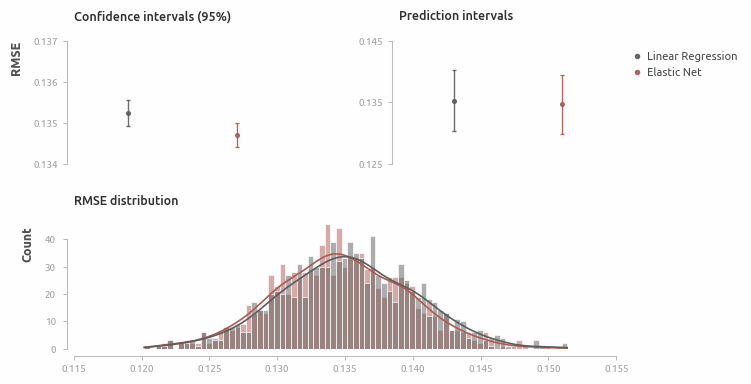

Image 'simulations.svg' successfully saved into 'img/Section4-Linear-models-research' directory


In [21]:
fig = plot_lr_enet_comparison(result_simulation_regressions)
# save plot
savefig('simulations', dir_save)

In [116]:
lr_coef = lr.params.to_frame(name='lr')
# add column with ci
lr_coef = pd.concat([
    lr_coef,
    lr.conf_int().rename(columns={0: 'ci_min', 1: 'ci_max'})
], axis=1)
lr_coef = lr_coef.reset_index(names='feature')

In [117]:
lr_coef

,feature,lr,ci_min,ci_max
0,Intercept,12.026297,12.019411,12.033183
1,lg_flrsfmean,0.144424,0.133645,0.155203
2,overallqual,0.087951,0.074537,0.101366
3,houseage,-0.085404,-0.098368,-0.072440
4,lg_lotarea,0.061270,0.053008,0.069532
5,overallcond,0.055904,0.047263,0.064546
6,bsmtqual,0.046012,0.036325,0.055698
7,garagecars,0.031576,0.020456,0.042695
8,kitchenqual,0.026770,0.016015,0.037526
9,exterqual,0.020048,0.009430,0.030665


In [118]:
comparing_df = lr_coef.merge(enet_coef, on='feature')

In [119]:
comparing_df

,feature,lr,ci_min,ci_max,enet
0,Intercept,12.026297,12.019411,12.033183,12.024989
1,lg_flrsfmean,0.144424,0.133645,0.155203,0.146236
2,overallqual,0.087951,0.074537,0.101366,0.094140
3,houseage,-0.085404,-0.098368,-0.072440,-0.087181
4,lg_lotarea,0.061270,0.053008,0.069532,0.062462
5,overallcond,0.055904,0.047263,0.064546,0.058608
6,bsmtqual,0.046012,0.036325,0.055698,0.042682
7,garagecars,0.031576,0.020456,0.042695,0.035288
8,kitchenqual,0.026770,0.016015,0.037526,0.028962
9,exterqual,0.020048,0.009430,0.030665,0.018759


In [120]:
comparing_df_plot = comparing_df.iloc[1:].copy()
comparing_df_plot.sort_values('lr', key=abs, ascending=True, inplace=True)
comparing_df_plot.reset_index(drop=True, inplace=True)
# xticks for plot
xticks = np.arange(1, len(comparing_df_plot['feature'])+1)
# yticks for plot
yticks = comparing_df_plot.index.tolist()
yticks = yticks[::-1]
yticks = [(i+1) for i in yticks]
ylabels = comparing_df_plot['feature'].values.tolist()
ylabels = ylabels[::-1]
ylabels = [str.upper(i) for i in ylabels]
labels = comparing_df_plot['feature']
# delta for points of scatterplots
delta_coeff = 0.125

Image 'coefficients_comparing.svg' successfully saved into 'img/Section4-Linear-models-research' directory


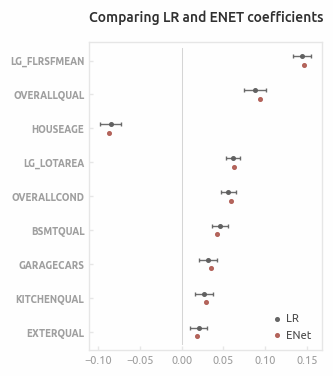

In [121]:
# figure
fig = plt.figure(figsize=(3, 4))
# scatterplots
ax = plt.scatter(
    x=comparing_df_plot['lr'], y=xticks+delta_coeff,
    s=7, color=palette[0], alpha=0.9
)
ax = plt.scatter(
    x=comparing_df_plot['enet'],y=xticks-delta_coeff,
    s=7, color=palette[1], alpha=0.9
)
# plot errorbar
yerr = ([comparing_df_plot['lr'] - comparing_df_plot['ci_min'],
         comparing_df_plot['ci_max'] - comparing_df_plot['lr']])
plt.errorbar(
    x=comparing_df_plot['lr'], y=xticks+delta_coeff,
    xerr=yerr, fmt='none', elinewidth=1, capsize=1.2,
    capthick=1, alpha=0.9)
# plot zero line
plt.axvline(
    0, ymin=0.02, ymax=0.98, color=palette[0], lw=0.75, alpha=0.25)
# legend
plt.legend(
    labels=['LR', 'ENet'], loc='lower right', handletextpad=-0.15)
# spines
ax.axes.spines[['top', 'right']].set_visible(True)
# ticks
plt.yticks(ticks=yticks, labels=ylabels, weight='bold', fontsize=7)
# title
plt.title('Comparing LR and ENET coefficients')
# remove grid
plt.grid(False)
# save plot
savefig('coefficients_comparing', dir_save)

### Save Data

In [122]:
simulation_datasets_dict['train_enet'] = data_cv
simulation_datasets_dict['features_enet'] = features_linear

In [123]:
estimators_dict['enet'] = enet
estimators_dict['lr'] = lr

In [124]:
evaluation_dict['cv_enet'] = enet_cv

In [125]:
features_dict['features_linear'] = features_linear

In [126]:
saveit(features_dict, 'features_dict', dir_save)

In [127]:
saveit(simulation_datasets_dict, 'simulation_datasets_dict', dir_save)

In [128]:
saveit(estimators_dict, 'estimators_dict', dir_save)

In [129]:
saveit(evaluation_dict, 'evaluation_dict', dir_save)

### Save Session

In [22]:
save_session(dir_save)

### Execution time

In [131]:
print(f'Execution time: {stopwatch.stop(start)}')

Execution time: 0:02:51
